In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
import random
from sklearn.metrics import classification_report

# Cấu hình thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Tiền xử lý dữ liệu hình ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
full_dataset = datasets.ImageFolder("E:\data_optimize\\train_fewshot", transform)
rare_dataset = datasets.ImageFolder("E:\\Fewshot_rare_data\\train", transform)

# Offset labels cho rare dataset để tránh trùng lặp
rare_dataset.samples = [(path, label + 5) for path, label in rare_dataset.samples]

# Kết hợp datasets
combined_dataset = ConcatDataset([full_dataset, rare_dataset])

# Mapping class indices
def get_class_indices(dataset):
    indices = {}
    for idx, (_, label) in enumerate(dataset):
        indices.setdefault(label, []).append(idx)
    return indices

class_indices = get_class_indices(combined_dataset)

# Kiểm tra số lượng mẫu mỗi lớp
for cls, idxs in class_indices.items():
    print(f"Class {cls}: {len(idxs)} samples")

Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 20 samples
Class 6: 20 samples


In [3]:
model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model.load_state_dict(torch.load("E:\Model save\Deep_learning_model\model\efficientnet_coffee (1).pth"))

# Loại bỏ classifier để chỉ lấy embeddings
model.classifier[1] = nn.Identity()
model = model.to(DEVICE).eval()

print("✅ EfficientNet feature extractor loaded successfully!")

def create_episode(dataset, class_indices, n_way=7, n_shot=5, n_query=5):
    selected_classes = random.sample(list(class_indices.keys()), n_way)
    support_imgs, query_imgs, support_labels, query_labels = [], [], [], []

    for new_label, class_id in enumerate(selected_classes):
        indices = class_indices[class_id]
        if len(indices) < n_shot + n_query:
            continue  # Bỏ qua lớp không đủ mẫu
        sampled_indices = random.sample(indices, n_shot + n_query)
        support_imgs += [dataset[i][0] for i in sampled_indices[:n_shot]]
        query_imgs += [dataset[i][0] for i in sampled_indices[n_shot:]]
        support_labels += [new_label] * n_shot
        query_labels += [new_label] * n_query

    return (torch.stack(support_imgs).to(DEVICE),
            torch.tensor(support_labels).to(DEVICE),
            torch.stack(query_imgs).to(DEVICE),
            torch.tensor(query_labels).to(DEVICE))

def proto_loss(support, query, n_way, n_shot, n_query):
    prototypes = support.view(n_way, n_shot, -1).mean(dim=1)
    distances = torch.cdist(query, prototypes)
    labels = torch.arange(n_way).repeat_interleave(n_query).to(DEVICE)
    return F.cross_entropy(-distances, labels)

def calculate_prototypes(model, loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE)
            emb = model(imgs)
            embeddings.append(emb.cpu())
            labels.append(labs)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)

    prototypes = []
    for label in range(7):  # Xác nhận đủ 7 lớp
        class_emb = embeddings[labels == label]
        prototypes.append(class_emb.mean(dim=0) if len(class_emb) > 0 else torch.zeros(embeddings[0].shape))
    return torch.stack(prototypes).to(DEVICE)

C:\Users\hoang\AppData\Local\Temp\ipykernel_25796\137167422.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("E:\Model save\Deep_learning

✅ EfficientNet feature extractor loaded successfully!


In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs, episodes_per_epoch, n_way, n_shot, n_query = 10, 5, 7, 10, 10

model.train()
for epoch in range(n_epochs):
    total_loss, total_correct, total_samples = 0, 0, 0

    for _ in range(episodes_per_epoch):
        s_imgs, s_labels, q_imgs, q_labels = create_episode(combined_dataset, class_indices, n_way, n_shot, n_query)
        s_emb, q_emb = model(s_imgs), model(q_imgs)

        loss = proto_loss(s_emb, q_emb, n_way, n_shot, n_query)

        # Accuracy Calculation
        prototypes = s_emb.view(n_way, n_shot, -1).mean(dim=1)
        distances = torch.cdist(q_emb, prototypes)
        preds = torch.argmin(distances, dim=1)
        total_correct += (preds == q_labels).sum().item()
        total_samples += q_labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/episodes_per_epoch:.4f}, Accuracy: {total_correct/total_samples*100:.2f}%")

Epoch [1/10], Loss: 0.2064, Accuracy: 92.57%
Epoch [2/10], Loss: 0.0802, Accuracy: 97.14%
Epoch [3/10], Loss: 0.1073, Accuracy: 97.43%
Epoch [4/10], Loss: 0.0403, Accuracy: 99.14%
Epoch [5/10], Loss: 0.0154, Accuracy: 99.43%
Epoch [6/10], Loss: 0.0097, Accuracy: 99.43%
Epoch [7/10], Loss: 0.0079, Accuracy: 99.71%
Epoch [8/10], Loss: 0.0073, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0048, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0222, Accuracy: 99.14%


In [6]:
# Tính lại prototypes sau fine-tuning
train_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False)
prototypes = calculate_prototypes(model, train_loader)
print("✅ Prototypes recalculated successfully!")

# Đánh giá trên tập test
test_dataset = datasets.ImageFolder("E:\\CLD_project\\test_balanced_fewshot", transform)
rare_test_dataset = datasets.ImageFolder("E:\\Fewshot_rare_data\\test", transform)
rare_test_dataset.samples = [(path, label + 5) for path, label in rare_test_dataset.samples]

combined_test_dataset = ConcatDataset([test_dataset, rare_test_dataset])
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

true_labels, pred_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        embeddings = model(imgs)
        distances = torch.cdist(embeddings, prototypes)
        preds = torch.argmin(distances, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

report = classification_report(true_labels, pred_labels, target_names=[
    'Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Nematode', 'Pink disease'], zero_division=1)

print(report)

✅ Prototypes recalculated successfully!
              precision    recall  f1-score   support

 Cerscospora       0.99      1.00      1.00       300
     Healthy       1.00      1.00      1.00       300
   Leaf rust       1.00      1.00      1.00       300
       Miner       0.97      1.00      0.98       300
       Phoma       0.98      0.99      0.99       300
    Nematode       0.90      0.92      0.91       163
Pink disease       1.00      0.92      0.96       271

    accuracy                           0.98      1934
   macro avg       0.98      0.98      0.98      1934
weighted avg       0.98      0.98      0.98      1934



              precision    recall  f1-score   support

 Cerscospora       0.99      1.00      1.00       300
     Healthy       1.00      1.00      1.00       300
   Leaf rust       1.00      1.00      1.00       300
       Miner       0.97      1.00      0.98       300
       Phoma       0.98      0.99      0.99       300
    Nematode       0.90      0.92      0.91       163
Pink disease       1.00      0.92      0.96       271

    accuracy                           0.98      1934
   macro avg       0.98      0.98      0.98      1934
weighted avg       0.98      0.98      0.98      1934



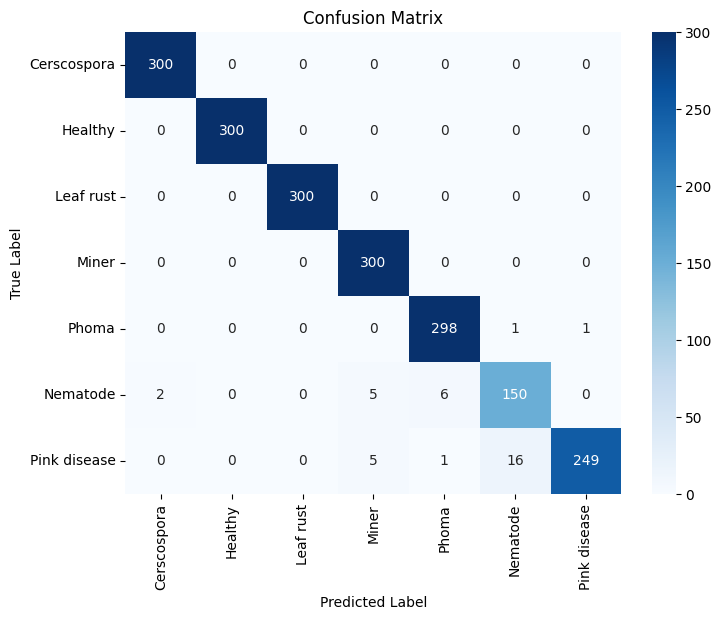

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
class_names = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Nematode', 'Pink disease']
report = classification_report(true_labels, pred_labels, target_names=class_names, zero_division=1)
print(report)

# Plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot
plot_confusion_matrix(true_labels, pred_labels, class_names)